In [167]:
import pandas as pd
import numpy as np

def create_time_features(df, order_time_col='order_create_time', session_end_col='session_end_time'):
    """
    Создает новые временные признаки на основе колонок с временными метками.
    
    Параметры:
    df - DataFrame с данными
    order_time_col - название колонки с временем создания заказа (timestamp)
    session_end_col - название колонки с временем окончания сессии (timestamp)
    
    Возвращает:
    DataFrame с добавленными новыми признаками
    """
    # Создаем копию DataFrame чтобы избежать предупреждений
    df = df.copy()
    
    # Преобразуем колонки в datetime, если они еще не в этом формате
    df[order_time_col] = pd.to_datetime(df[order_time_col])
    df[session_end_col] = pd.to_datetime(df[session_end_col])
    
    # 1. Разница между окончанием сессии и созданием заказа (в секундах)
    df['time_to_order_seconds'] = (df[session_end_col] - df[order_time_col]).dt.total_seconds()
    
    # 2. Признаки времени создания заказа
    df['order_hour'] = df[order_time_col].dt.hour
    df['order_day_of_week'] = df[order_time_col].dt.dayofweek  # 0-понедельник, 6-воскресенье
    df['order_day_of_month'] = df[order_time_col].dt.day
    df['order_month'] = df[order_time_col].dt.month
    df['order_week_of_year'] = df[order_time_col].dt.isocalendar().week
    df['order_is_weekend'] = df[order_time_col].dt.dayofweek >= 5
    
    # 3. Признаки времени окончания сессии
    df['session_end_hour'] = df[session_end_col].dt.hour
    df['session_end_day_of_week'] = df[session_end_col].dt.dayofweek
    df['session_end_day_of_month'] = df[session_end_col].dt.day
    df['session_end_month'] = df[session_end_col].dt.month
    df['session_end_week_of_year'] = df[session_end_col].dt.isocalendar().week
    df['session_end_is_weekend'] = df[session_end_col].dt.dayofweek >= 5
    
    # 4. Разница во времени в разных единицах
    df['time_to_order_minutes'] = df['time_to_order_seconds'] / 60
    df['time_to_order_hours'] = df['time_to_order_seconds'] / 3600
    
    # 5. Временные категории (утро/день/вечер/ночь)
    bins = [-1, 6, 12, 18, 23]
    labels = ['night', 'morning', 'afternoon', 'evening']
    df['order_time_of_day'] = pd.cut(df['order_hour'], bins=bins, labels=labels)
    df['session_end_time_of_day'] = pd.cut(df['session_end_hour'], bins=bins, labels=labels)
    
    # 6. Является ли заказ сделан в тот же день, что и сессия
    df['same_day_order'] = df[order_time_col].dt.date == df[session_end_col].dt.date
    
    df['gap_negative'] = df['time_to_order_seconds'] < 0
    df['is_midnight_session'] = df['session_end_hour'].isin([0, 1, 2, 3])
    df['order_during_business_hours'] = df['order_hour'].between(9, 18)
    
    df['hour_diff'] = df['session_end_hour'] - df['order_hour']

    df['order_time_fraction'] = df[order_time_col].dt.hour * 3600 + df[order_time_col].dt.minute * 60 + df[order_time_col].dt.second
    df['order_time_fraction'] /= 86400  # нормировка по числу секунд в сутках

    
    # 7. Сезонность (времена года)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'winter'
        elif month in [3, 4, 5]:
            return 'spring'
        elif month in [6, 7, 8]:
            return 'summer'
        else:
            return 'autumn'
    
    df['order_season'] = df['order_month'].apply(get_season)
    df['session_end_season'] = df['session_end_month'].apply(get_season)
    
    return df

In [168]:
tst_old = pd.read_parquet('data_old/test.parquet')
tst_old

,order_id,create_time,good_id,price,sessionkey_id
0,1350922,1976-02-05 15:08:37,9896348,1143,132744630
1,1354989,1976-02-07 15:26:00,69445048,1707,133161905
2,1352637,1976-02-06 11:43:58,70607886,576,132792626
3,1350050,1976-02-05 11:26:19,61918401,436,132683062
4,1341733,1976-02-01 19:36:32,37964900,573,131789790
...,...,...,...,...,...
17191,1358397,1976-02-09 16:13:20,74484779,236,131980166
17192,1357968,1976-02-09 14:30:59,75277186,108,133527708
17193,1358835,1976-02-09 18:39:45,75382827,602,133585500
17194,1365692,1976-02-12 17:50:18,76012025,818,133876415


In [169]:
tr = pd.read_parquet('data/train.parquet')
tst = pd.read_parquet('data/test.parquet')

display(tr)

target = tr.target
tr = tr.drop(columns='target')

order_id = tst.order_id
tst = tst.drop(columns='order_id')


tr = create_time_features(tr)
tr = tr.drop(columns=['order_create_time', 'session_end_time'])

tst = create_time_features(tst)
tst = tst.drop(columns=['order_create_time', 'session_end_time'])

,target,order_create_time,session_end_time,model_1,model_2,model_3,model_4,model_5
0,1,1975-12-26 09:30:08,1975-12-26 09:21:03.393,0.798127,0.644805,0.039843,1,0.430339
1,0,1975-12-26 10:28:57,1975-12-26 11:01:03.407,-0.573826,0.220081,0.020889,0,0.177593
2,1,1975-12-25 11:24:28,1975-12-25 11:23:12.517,-0.665887,0.644805,0.039810,0,0.431897
3,1,1975-12-26 14:16:06,1975-12-26 14:29:57.153,-0.284625,0.644805,0.040026,0,0.432045
4,0,1975-12-26 18:21:47,1975-12-26 18:17:54.257,-1.710108,-0.221541,0.020585,0,0.174115
...,...,...,...,...,...,...,...,...
104590,1,1975-12-16 12:11:32,1975-12-16 12:56:06.990,-0.784541,0.220081,0.020901,0,0.188639
104591,1,1975-11-08 11:29:50,1975-11-07 23:55:00.773,-0.504846,0.220081,0.029831,0,0.175063
104592,0,1975-11-12 09:14:35,1975-11-12 09:15:26.047,-1.710108,-0.221541,0.021167,0,0.191408
104593,1,1975-11-10 17:28:07,1975-11-10 17:23:02.973,-0.403279,0.644805,0.040814,0,0.452594


In [170]:
# Допустим, optimal_tau найден как выше
tau = 0

# бинарка: 1 — если Δ <= τ (т.е. «скорее колл-центр»), иначе 0
tr['callcenter_rule'] = (tr['time_to_order_seconds'] <= tau).astype(int)
tst['callcenter_rule'] = (tst['time_to_order_seconds'] <= tau).astype(int)


threshold_hard = -28*60
tr['callcenter_hard'] = (tr['time_to_order_seconds'] < threshold_hard).astype(int)
tst['callcenter_hard'] = (tst['time_to_order_seconds'] < threshold_hard).astype(int)

[LightGBM] [Info] Number of positive: 29679, number of negative: 53997
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 83676, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.354690 -> initscore=-0.598489
[LightGBM] [Info] Start training from score -0.598489
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.957484	valid's auc: 0.955227
[100]	train's auc: 0.959313	valid's auc: 0.95612
[150]	train's auc: 0.961078	valid's auc: 0.956968
[200]	train's auc: 0.962698	valid's auc: 0.957365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	train's auc: 0.964117	valid's auc: 0.957548
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	train's auc: 0.965582	valid's auc: 0.9575

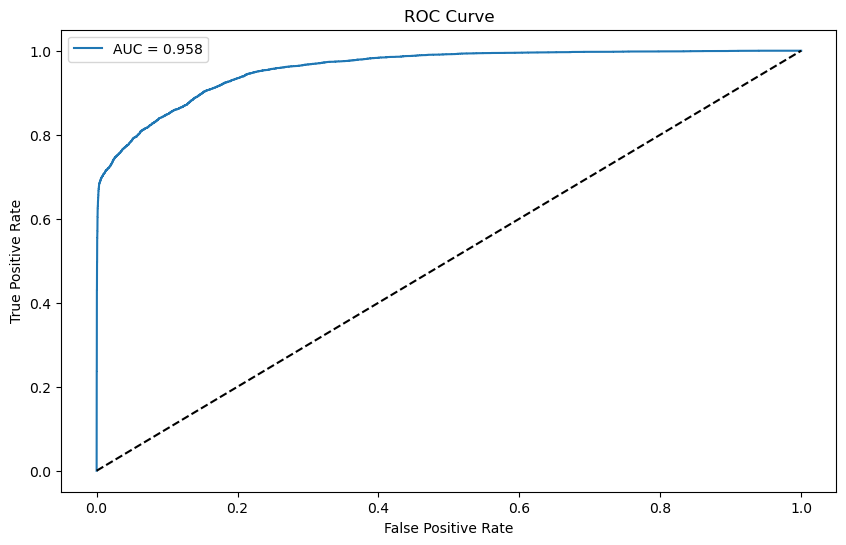

In [171]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# Обработка категориальных признаков
cat_features = tr.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
numeric_features = tr.select_dtypes(include=np.number).columns.tolist()

for col in cat_features:
    if col in tr.columns:
        tr[col] = tr[col].astype('category')

X = tr
y = target

# Стратифицированное разделение
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Создание Dataset для LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=train_data)

# Параметры модели
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'learning_rate': 0.032100074071180665,
	'num_leaves': 38,
	'max_depth': 8,
	'feature_fraction': 0.65268762313293,
	'bagging_fraction': 0.843860662378207,
	'bagging_freq': 2,
	'min_data_in_leaf': 73,
	'verbose': 1,
    'seed': 42,
}

# Обучение модели
model = lgb.train(
    params,
    train_data,
    num_boost_round=300,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
		lgb.early_stopping(stopping_rounds=50, verbose=True),
		lgb.log_evaluation(period=50)
	],
)

# Прогноз и оценка
val_probs = model.predict(X_val, num_iteration=model.best_iteration)
roc_auc = roc_auc_score(y_val, val_probs)
print(f"\nROC-AUC: {roc_auc:.4f}")

# Визуализация ROC-кривой
fpr, tpr, _ = roc_curve(y_val, val_probs)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [172]:
# Приведение типов в tst к тем же категориям, что и в tr
for col in cat_features:
    if col in tst.columns:
        # Сделать колонку категориальной
        tst[col] = tst[col].astype('category')
        # Установить те же категории, что и в обучении
        tst[col] = tst[col].cat.set_categories(tr[col].cat.categories)


tst['pred'] = model.predict(tst, num_iteration=model.best_iteration)
tst['order_id'] = order_id

tst[['order_id', 'pred']].to_csv('bbbbbbbbbbbbb.csv', index=False)

In [173]:
ы

NameError: name 'ы' is not defined

c:\Users\Admin\anaconda3\Lib\site-packages\shap\explainers\_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


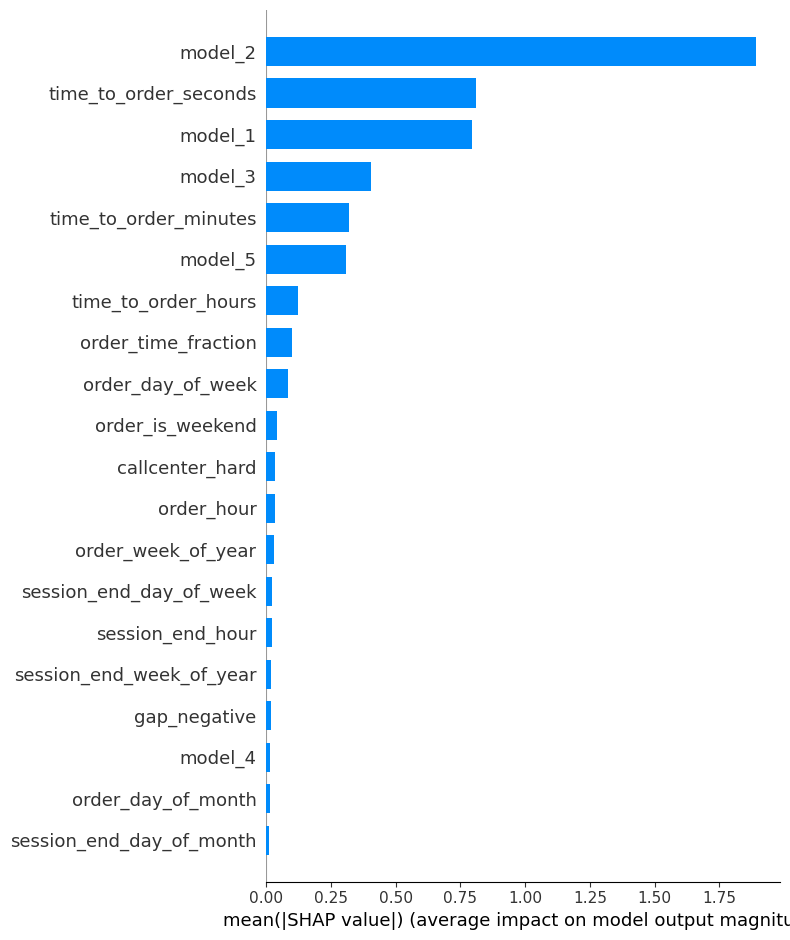

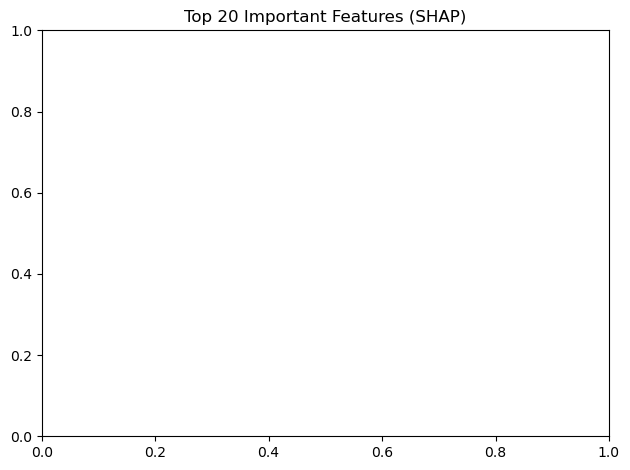

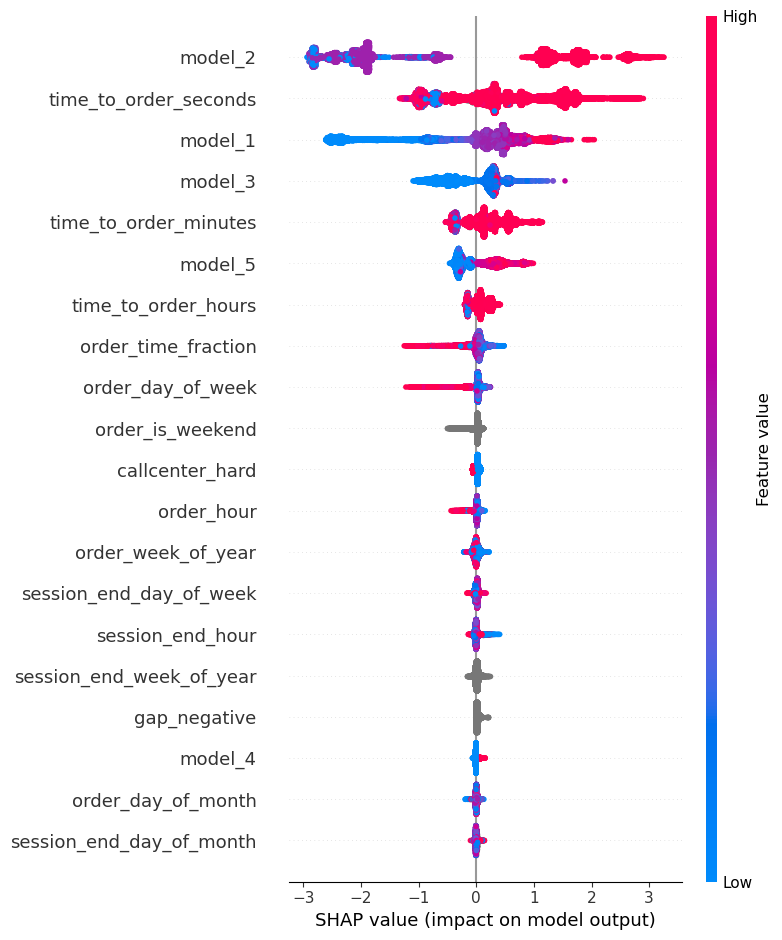

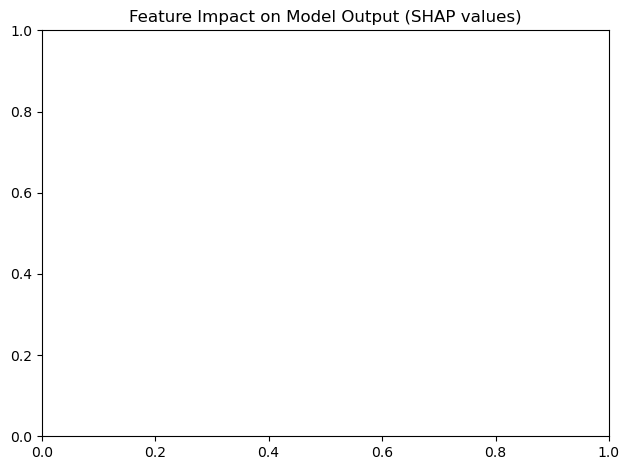

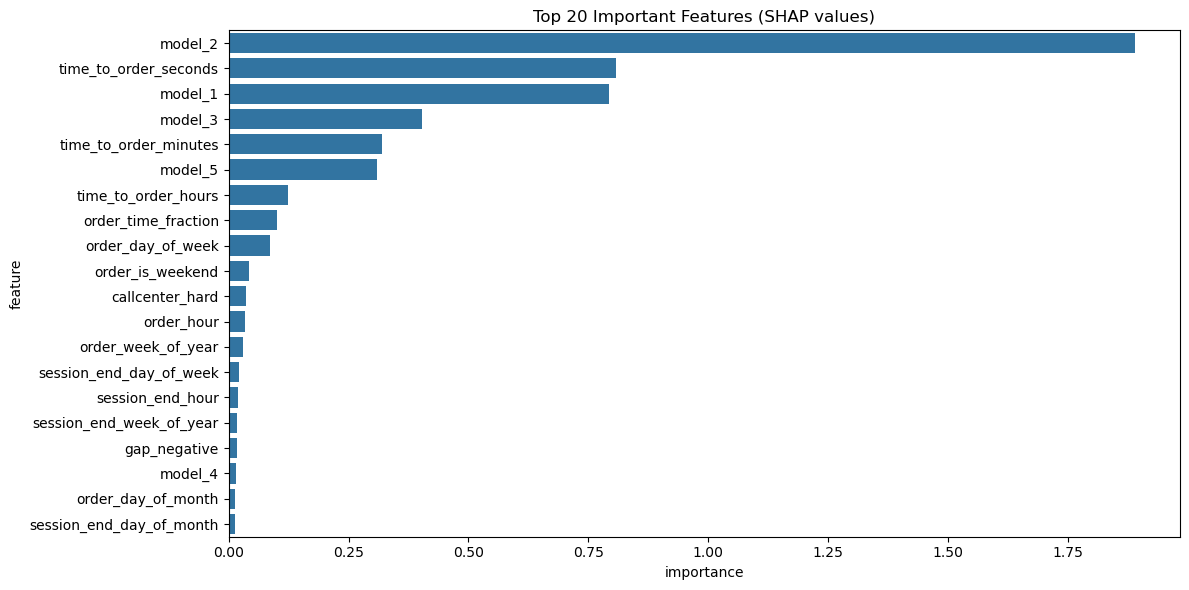

In [174]:
import shap

# Инициализация SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Визуализация summary plot (аналог важности признаков)
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=20)
plt.title('Top 20 Important Features (SHAP)')
plt.tight_layout()
plt.show()

# Дополнительно: более детальная визуализация SHAP значений
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_val, plot_type="dot", max_display=20)
plt.title('Feature Impact on Model Output (SHAP values)')
plt.tight_layout()
plt.show()

# Альтернативный вариант - DataFrame с важностью признаков по SHAP
shap_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=shap_importance.head(20))
plt.title('Top 20 Important Features (SHAP values)')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# читаем данные
tr = pd.read_parquet('data/train.parquet')
tr['order_create_time'] = pd.to_datetime(tr['order_create_time'])
tr['session_end_time'] = pd.to_datetime(tr['session_end_time'])

# считаем дельту (секунды)
tr['time_to_order_seconds'] = (tr['session_end_time'] - tr['order_create_time']).dt.total_seconds()

# правило A: внутри сессии -> онлайн (target=0)
mask_A = tr['time_to_order_seconds'] < 0
n_A = mask_A.sum()
correct_A = ((tr.loc[mask_A, 'target'] == 0).sum())
print(f"Гипотеза A: внутри сессии (Δ<0) всего {n_A} записей, из них онлайн={correct_A} ({correct_A/n_A:.4%})")

# правило B: после сессии -> колл-центр (target=1)
mask_B = tr['time_to_order_seconds'] > 0
n_B = mask_B.sum()
correct_B = ((tr.loc[mask_B, 'target'] == 1).sum())
print(f"Гипотеза B: после сессии (Δ>0) всего {n_B} записей, из них колл-центр={correct_B} ({correct_B/n_B:.4%})")

# нарушения
false_A = n_A - correct_A
false_B = n_B - correct_B
print(f"\nНарушения правила A (expected 0): {false_A}")
print(f"Нарушения правила B (expected 1): {false_B}")
print(f"Всего неклассифицируемых (Δ==0): {(tr['time_to_order_seconds']==0).sum()}")


Гипотеза A: внутри сессии (Δ<0) всего 61399 записей, из них онлайн=32488 (52.9129%)
Гипотеза B: после сессии (Δ>0) всего 42572 записей, из них колл-центр=7818 (18.3642%)

Нарушения правила A (expected 0): 28911
Нарушения правила B (expected 1): 34754
Всего неклассифицируемых (Δ==0): 0


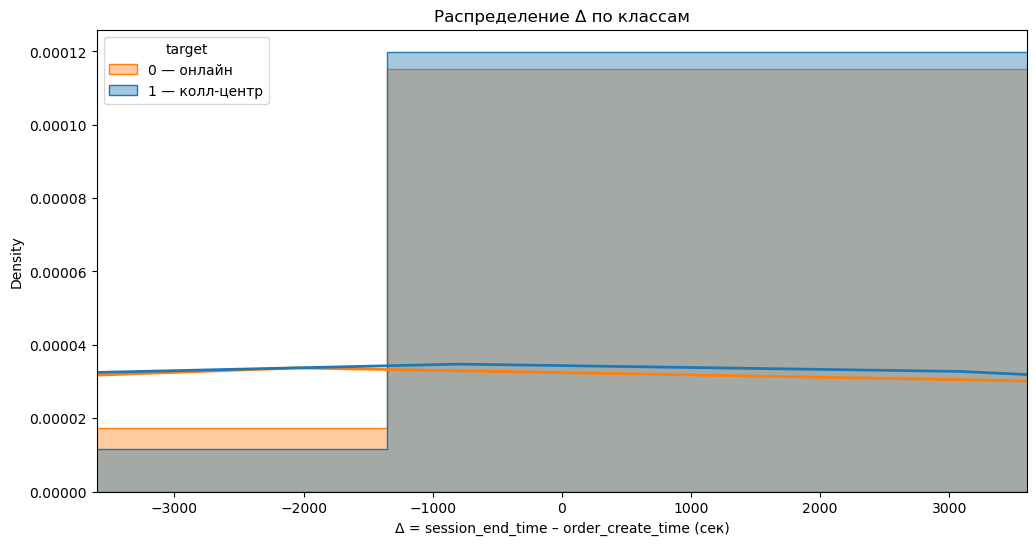

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Предполагаем, что tr уже загружен и содержит колонки ['time_to_order_seconds', 'target']
plt.figure(figsize=(12, 6))
sns.histplot(data=tr, x='time_to_order_seconds', hue='target', 
             bins=200, element='step', stat='density', common_norm=False, alpha=0.4)
sns.kdeplot(data=tr, x='time_to_order_seconds', hue='target', 
            lw=2, common_norm=False)
plt.xlim(-3600, 3600)         # например, ограничимся ±1 часом
plt.xlabel('Δ = session_end_time – order_create_time (сек)')
plt.title('Распределение Δ по классам')
plt.legend(title='target', labels=['0 — онлайн', '1 — колл-центр'])
plt.show()


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'verbose': -1,
        'seed': 42,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 16, 64),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
    }

    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=300,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=30, verbose=False),
        ],
    )

    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    score = roc_auc_score(y_val, val_preds)
    return score

# ⚙️ Запуск Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("\n✅ Best ROC-AUC: {:.4f}".format(study.best_value))
print("📌 Best params:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")


[I 2025-05-19 00:08:52,321] A new study created in memory with name: no-name-98020fa0-42fe-4b26-9843-ef462ebe9024
[I 2025-05-19 00:08:52,652] Trial 0 finished with value: 0.9562981854101602 and parameters: {'learning_rate': 0.24268038105909745, 'num_leaves': 60, 'max_depth': 7, 'feature_fraction': 0.7121723856928086, 'bagging_fraction': 0.9000235014881184, 'bagging_freq': 4, 'min_data_in_leaf': 38}. Best is trial 0 with value: 0.9562981854101602.
[I 2025-05-19 00:08:53,239] Trial 1 finished with value: 0.9564138124237614 and parameters: {'learning_rate': 0.11568158354474757, 'num_leaves': 37, 'max_depth': 3, 'feature_fraction': 0.8074143288670884, 'bagging_fraction': 0.6126710132135985, 'bagging_freq': 4, 'min_data_in_leaf': 71}. Best is trial 1 with value: 0.9564138124237614.
[I 2025-05-19 00:08:53,679] Trial 2 finished with value: 0.9563913239854644 and parameters: {'learning_rate': 0.26249754891787, 'num_leaves': 30, 'max_depth': 3, 'feature_fraction': 0.7821821726353418, 'bagging_f

KeyboardInterrupt: 